In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from pathlib import Path
import re
import glob
import os
from scipy import stats

In [2]:
def plot_top_genes_across_k(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01):
    """
    Create heatmap with GEPs (at different K values) on y-axis and genes on x-axis.

    Expected file format for each k:
      - File: f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
      - Each ROW is a GEP at a specific K (e.g., 'GEP1', 'GEP2', ...).
      - Each COLUMN is a gene.
      - Entry is the gene's score in that GEP.
    """
    all_top_genes = {}
    all_gene_sets = set()
    
    # Load data for each k
    for k in k_range:
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        
        # Rows = GEPs, columns = genes
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)
        
        # Number of genes to keep (top X% of *columns*)
        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))
        
        # For each GEP (row), get its top genes
        for gep_name, row in spectra_df.iterrows():
            # Uniquely tag each GEP with its K value, e.g. "k5_GEP1"
            gep_id = f"k{k}_{gep_name}"
            
            top_genes = row.nlargest(n_top_genes).index.tolist()
            all_top_genes[gep_id] = top_genes
            all_gene_sets.update(top_genes)
    
    # Create binary matrix: rows = GEPs, columns = genes
    all_genes_sorted = sorted(all_gene_sets)
    binary_matrix = pd.DataFrame(
        0,
        index=list(all_top_genes.keys()),
        columns=all_genes_sorted,
        dtype=int,
    )
    
    for gep, genes in all_top_genes.items():
        binary_matrix.loc[gep, genes] = 1
    
    # Optional: cluster genes by co-occurrence across GEPs
    if binary_matrix.shape[1] > 1:  # need at least 2 genes to cluster
        gene_linkage = linkage(binary_matrix.T, method='average', metric='euclidean')
        gene_order = dendrogram(gene_linkage, no_plot=True)['leaves']
        binary_matrix = binary_matrix.iloc[:, gene_order]
    
    # Plot
    fig_width = max(20, len(binary_matrix.columns) / 10)
    fig, ax = plt.subplots(figsize=(fig_width, 16))
    sns.heatmap(
        binary_matrix,
        cmap='YlOrRd',
        cbar_kws={'label': f'Gene in top {top_pct*100:.1f}%'},
        xticklabels=True,
        yticklabels=binary_matrix.index,   # full labels (k5_GEP1, ..., k10_GEP10)
        ax=ax
    )

    ax.set_xlabel("Genes", fontsize=12)
    ax.set_ylabel("GEP (includes K)", fontsize=16)
    ax.set_title(f"Top {top_pct*100:.1f}% Genes for each GEP across K values", fontsize=14)

    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    
    # Return fig and matrix so you can unpack them
    return fig, binary_matrix


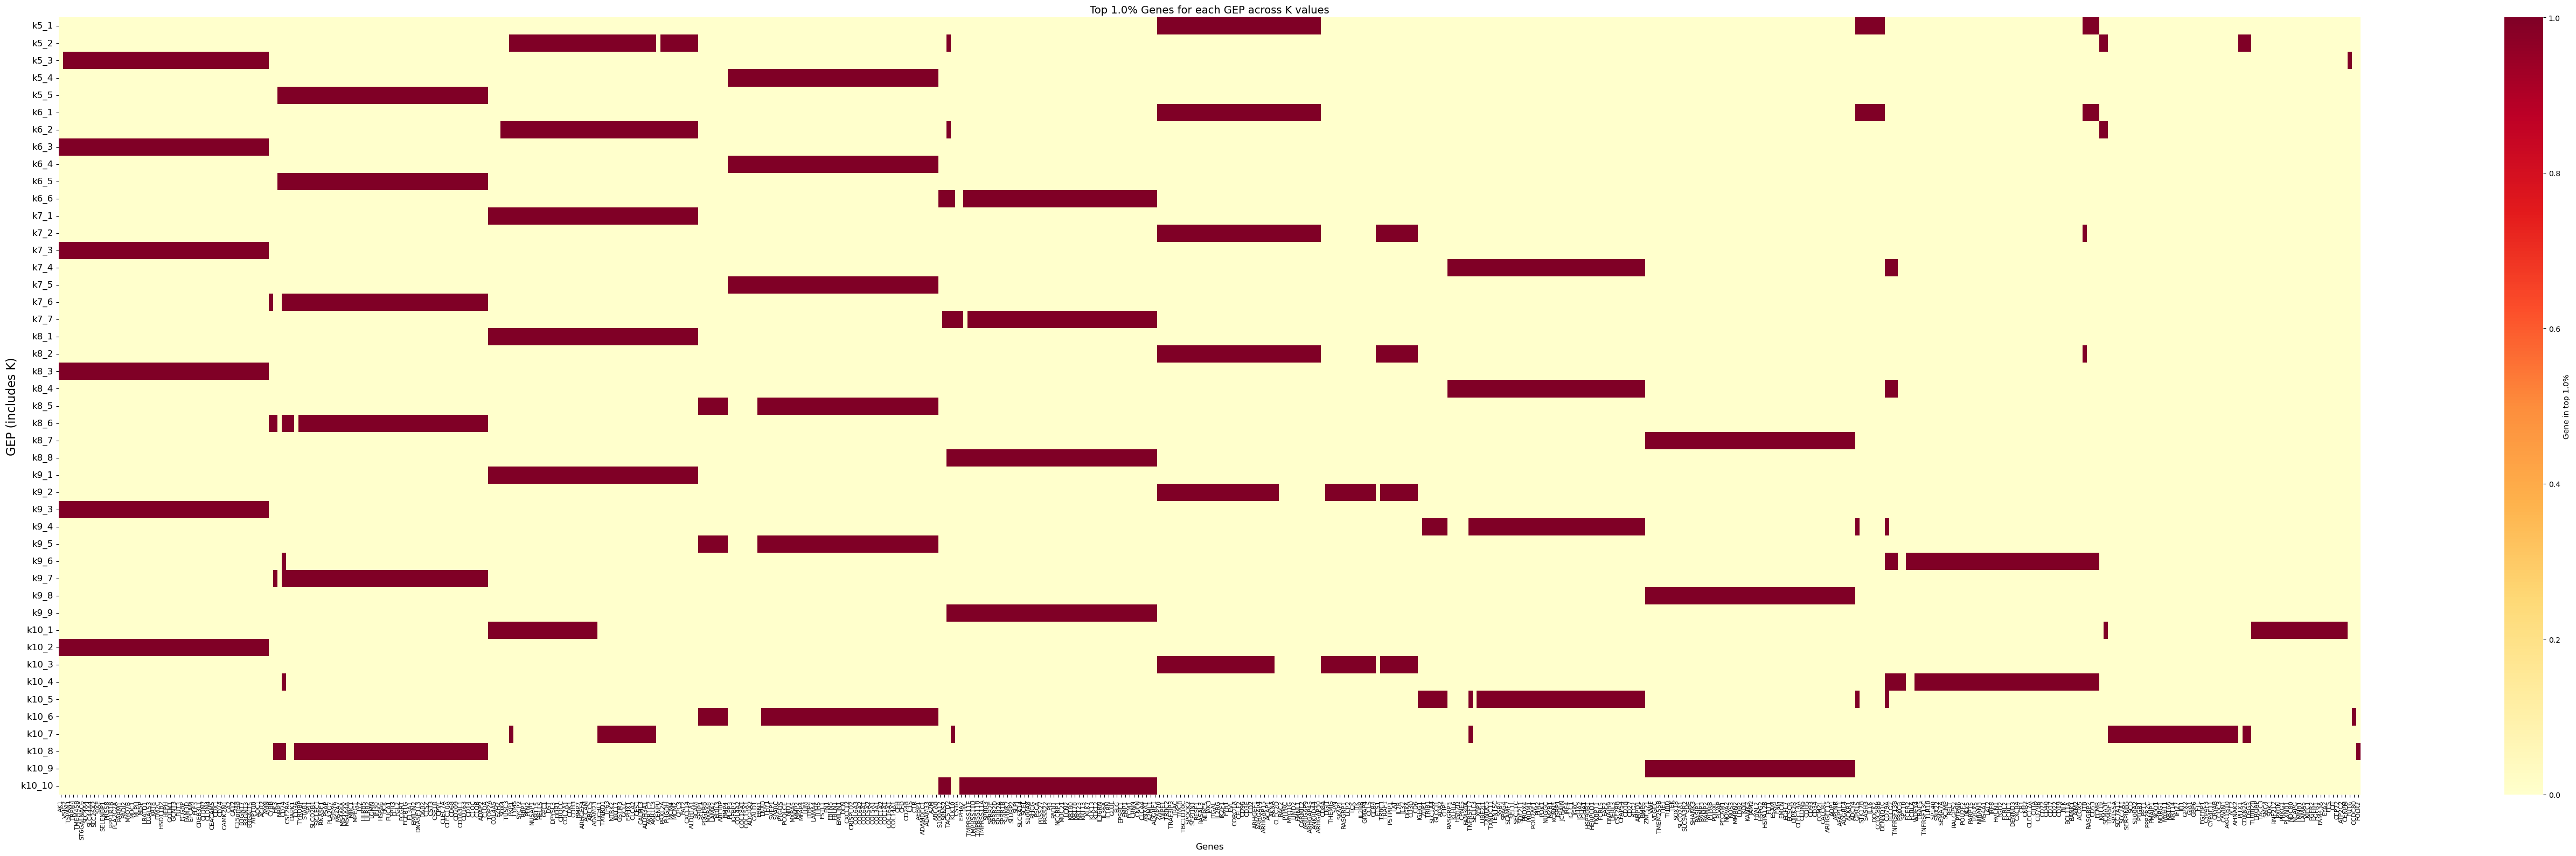

In [3]:
k_range = range(5, 11)
fig, matrix = plot_top_genes_across_k(
    'all_datasets_consensus/S1_spectra_vector_subset',
    'anal_pc5_c21_S1.filtered',
    k_range
)
plt.show()

In [4]:
def plot_spectra_heatmaps_per_k(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01):
    """
    Create separate heatmaps for each K showing only the top genes
    for that K value.

    Expected input file format:
        - Rows = GEPs (e.g., k5_GEP1, k5_GEP2, ...)
        - Columns = genes
    """
    n_ks = len(k_range)
    n_cols = 3
    n_rows = int(np.ceil(n_ks / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 4*n_rows))
    axes = axes.flatten()
    
    for idx, k in enumerate(k_range):

        # ---- Load spectra matrix for this K ----
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)

        # Number of genes available
        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))

        # ---- Collect top genes for all GEPs (rows) ----
        top_genes_per_gep = []
        for gep_name, row in spectra_df.iterrows():
            top_genes = row.nlargest(n_top_genes).index
            top_genes_per_gep.extend(top_genes)

        # Unique set of top genes for this K
        unique_top_genes = sorted(set(top_genes_per_gep))

        # ---- Subset matrix to only top genes ----
        spectra_subset = spectra_df[unique_top_genes]

        # ---- Plot heatmap ----
        sns.heatmap(
            spectra_subset,
            cmap='viridis',
            ax=axes[idx],
            xticklabels=True,
            yticklabels=True,
            cbar=True
        )

        axes[idx].set_title(f"K = {k}")
        axes[idx].set_ylabel("GEP")
        axes[idx].set_xlabel(f"Top {top_pct*100:.1f}% genes")

        # Make x-axis labels smaller + rotated + spaced
        axes[idx].tick_params(axis='x', labelsize=6, rotation=90, pad=2)

    # ---- Hide unused subplot panels ----
    for idx in range(len(k_range), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    return fig

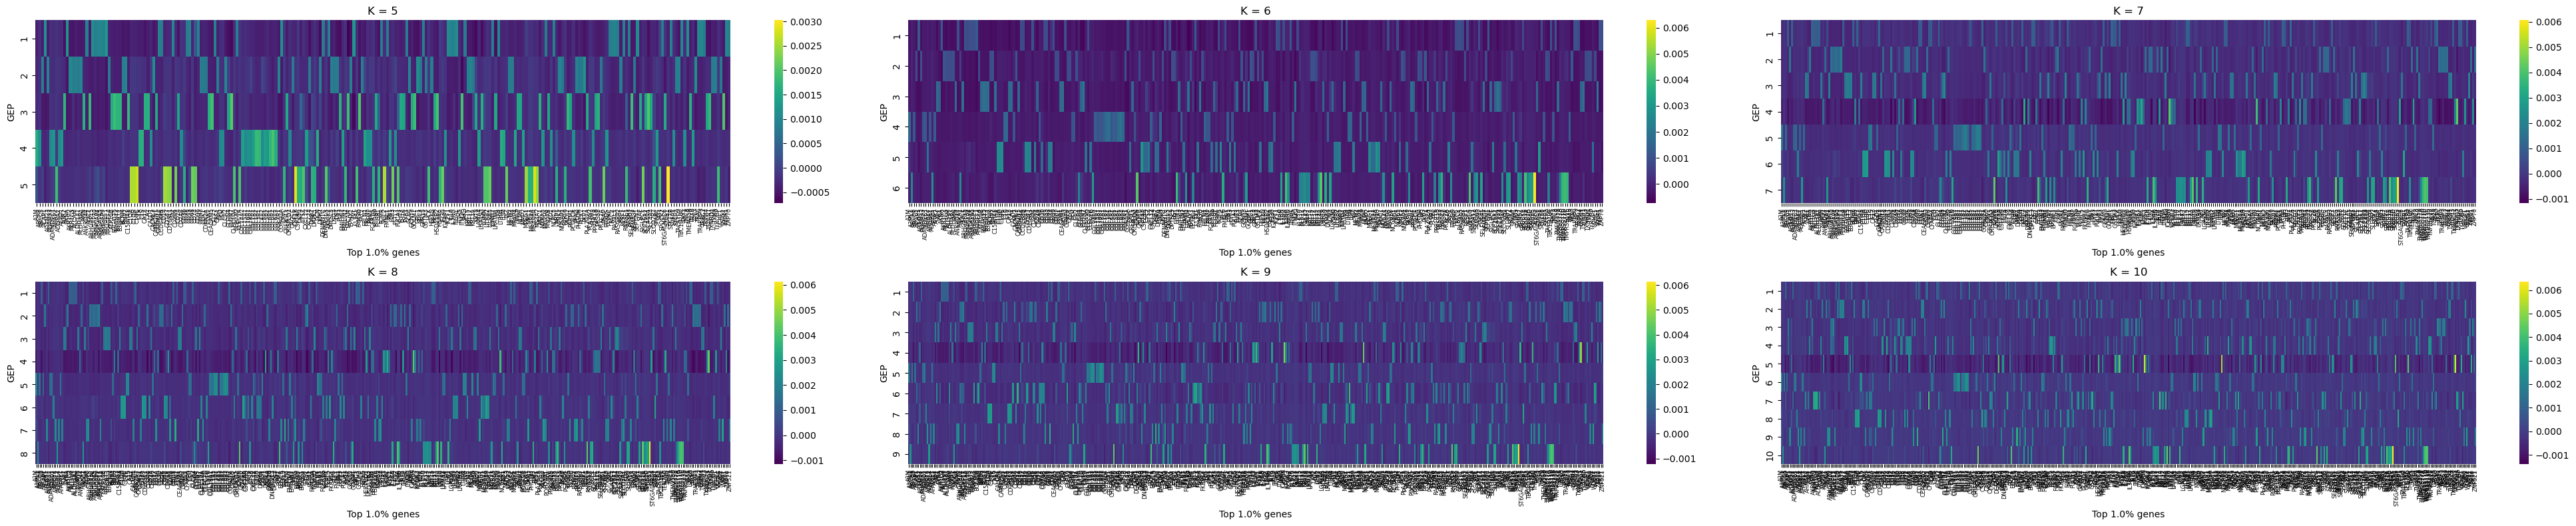

In [5]:
# Usage
fig = plot_spectra_heatmaps_per_k('all_datasets_consensus/S1_spectra_vector_subset', 'anal_pc5_c21_S1.filtered', range(5, 11))
plt.show()

## how often to genes show up across GEPs for a certain K value?

In [6]:
def plot_dotplot_genes_across_k(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01):
    """
    Dot plot showing gene presence across different k values.
    Size/color = how many GEPs at that k contain the gene in the top %.
    """
    gene_counts_by_k = {}
    
    for k in k_range:
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)
        
        # Number of genes to keep (top X% of columns)
        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))
        
        gene_counts = {}
        
        # Loop over each GEP (each row)
        for gep_name, row in spectra_df.iterrows():
            top_genes = row.nlargest(n_top_genes).index
            
            for gene in top_genes:
                gene_counts[gene] = gene_counts.get(gene, 0) + 1
        
        gene_counts_by_k[k] = gene_counts
    
    # Collect all genes
    all_genes = set()
    for counts in gene_counts_by_k.values():
        all_genes.update(counts.keys())
    
    # Build matrix: rows=genes, columns=K values
    dot_data = pd.DataFrame(0, index=sorted(all_genes), columns=k_range)
    for k, counts in gene_counts_by_k.items():
        for gene, count in counts.items():
            dot_data.loc[gene, k] = count
    
    # Keep most frequently occurring genes
    gene_appearance = dot_data.sum(axis=1)
    top_genes_to_plot = gene_appearance.nlargest(100).index
    
    dot_data_subset = dot_data.loc[top_genes_to_plot, :]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 20))
    
    max_count = dot_data_subset.max().max()
    
    for i, gene in enumerate(dot_data_subset.index):
        for j, k in enumerate(k_range):
            count = dot_data_subset.loc[gene, k]
            if count > 0:
                ax.scatter(j, i, s=count*50, c=count,
                           cmap='Reds', vmin=0, vmax=max_count,
                           edgecolors='black', linewidth=0.5)
    
    ax.set_xticks(range(len(k_range)))
    ax.set_xticklabels(k_range)
    ax.set_yticks(range(len(top_genes_to_plot)))
    ax.set_yticklabels(top_genes_to_plot, fontsize=6)
    
    ax.set_xlabel("K value", fontsize=12)
    ax.set_ylabel("Genes", fontsize=12)
    ax.set_title("Gene appearance in top % across K values\n(size = # of GEPs)", fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Colorbar
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=max_count))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Number of GEPs", rotation=270, labelpad=20)
    
    plt.tight_layout()
    return fig, dot_data


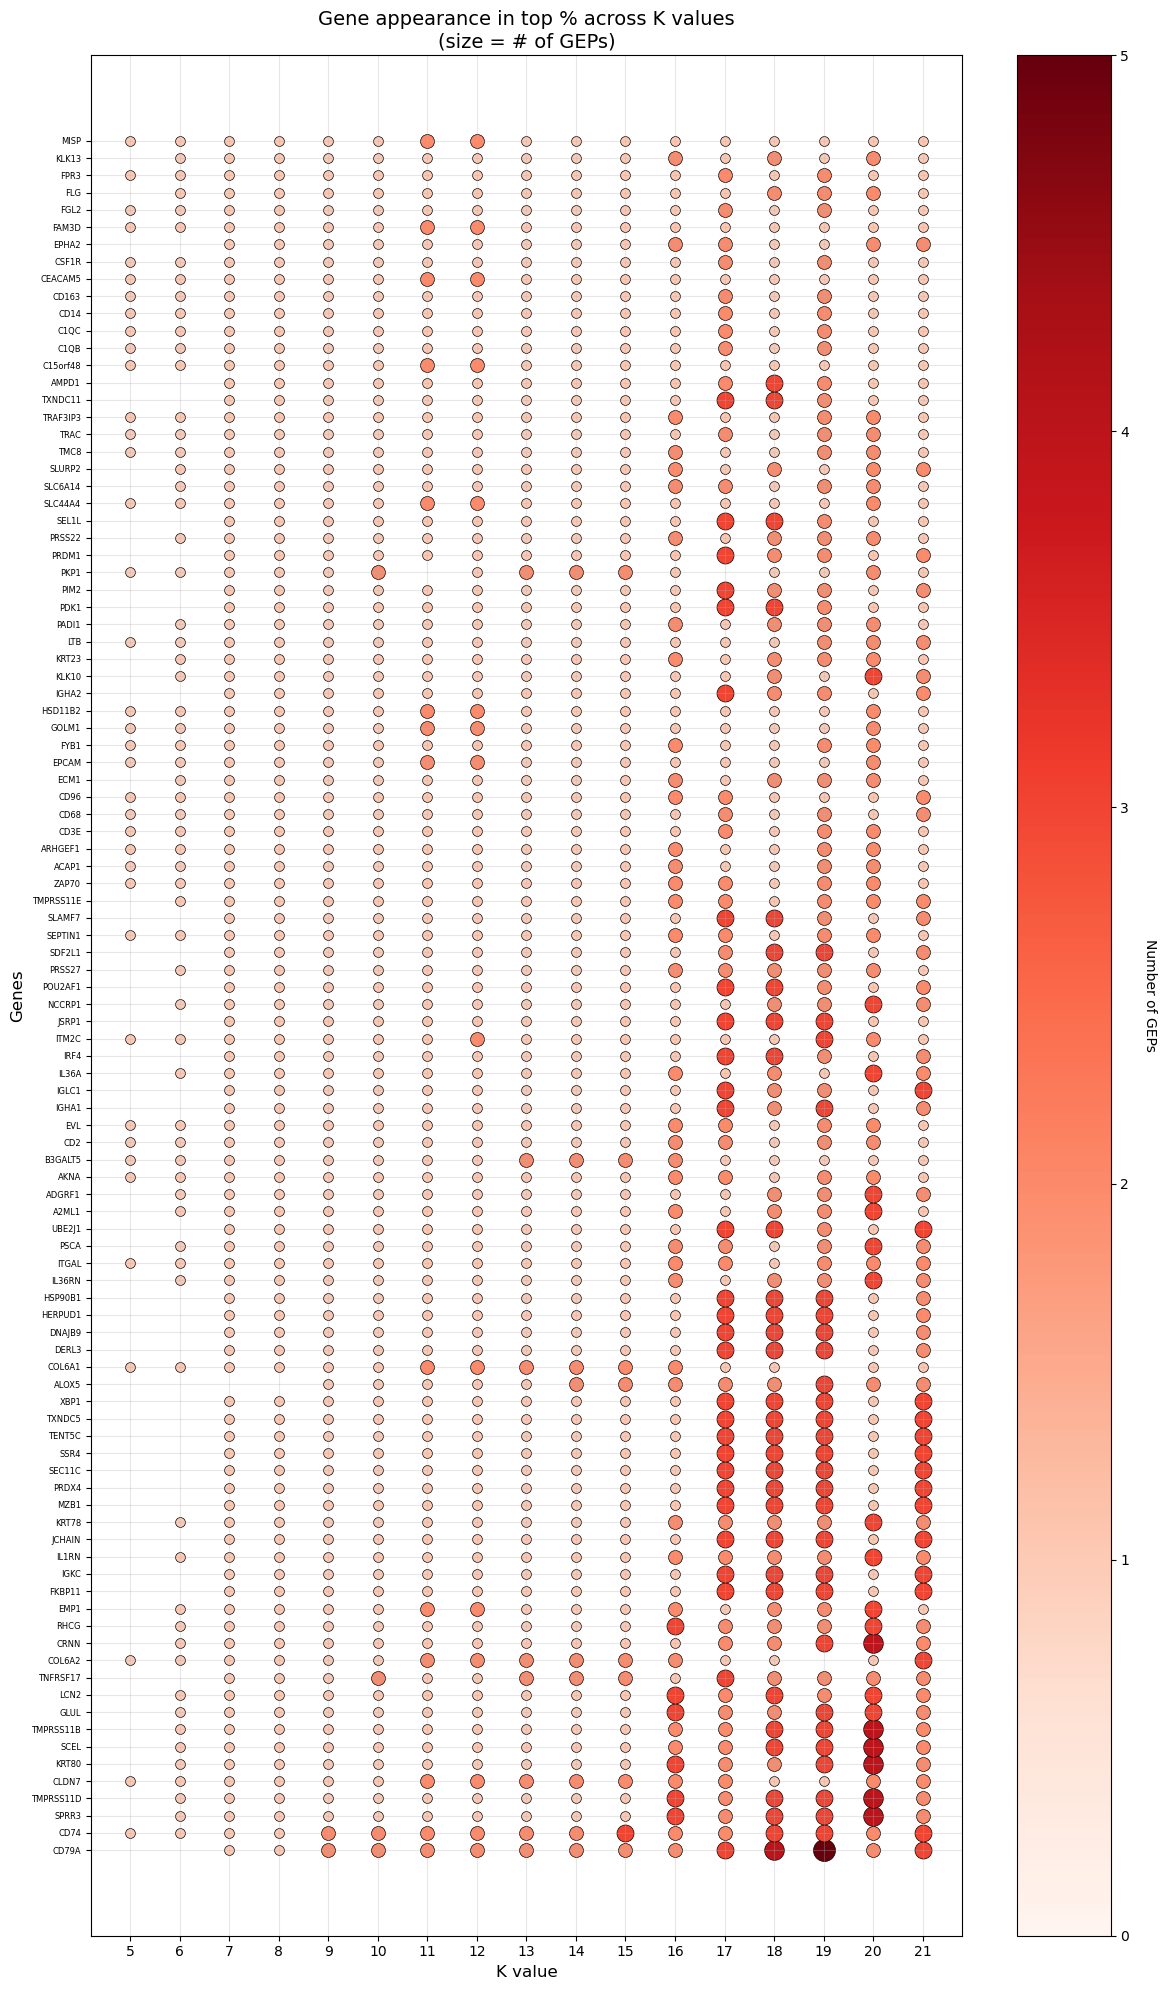

In [7]:
fig, data = plot_dotplot_genes_across_k(
    'all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs',
    'anal_pc5_c21_S1.filtered',
    range(5, 22)
)
plt.show()


In [8]:
def plot_gene_persistence(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01):
    """
    Count how many K values each gene appears in the top % of GEPs.
    Produces a histogram of how persistent genes are across K values.
    """
    gene_k_appearances = {}
    
    for k in k_range:
        # Fixed path (same as other functions)
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)
        
        # Number of top genes per GEP (top % of columns)
        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))
        
        # Collect ALL top genes across GEPs for this K
        all_top_genes_this_k = set()
        
        for gep_name, row in spectra_df.iterrows():   # iterate rows (GEPs)
            top_genes = row.nlargest(n_top_genes).index
            all_top_genes_this_k.update(top_genes)
        
        # Record which K each gene appears in
        for gene in all_top_genes_this_k:
            if gene not in gene_k_appearances:
                gene_k_appearances[gene] = []
            gene_k_appearances[gene].append(k)
    
    # Count appearances for histogram
    appearance_counts = {gene: len(ks) for gene, ks in gene_k_appearances.items()}
    counts = pd.Series(appearance_counts)
    
    # Plot histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    counts.value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue')
    
    ax.set_xlabel('Number of K values in which gene appears in top %', fontsize=12)
    ax.set_ylabel('Number of genes', fontsize=12)
    ax.set_title('Gene persistence across K values', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    return fig, counts

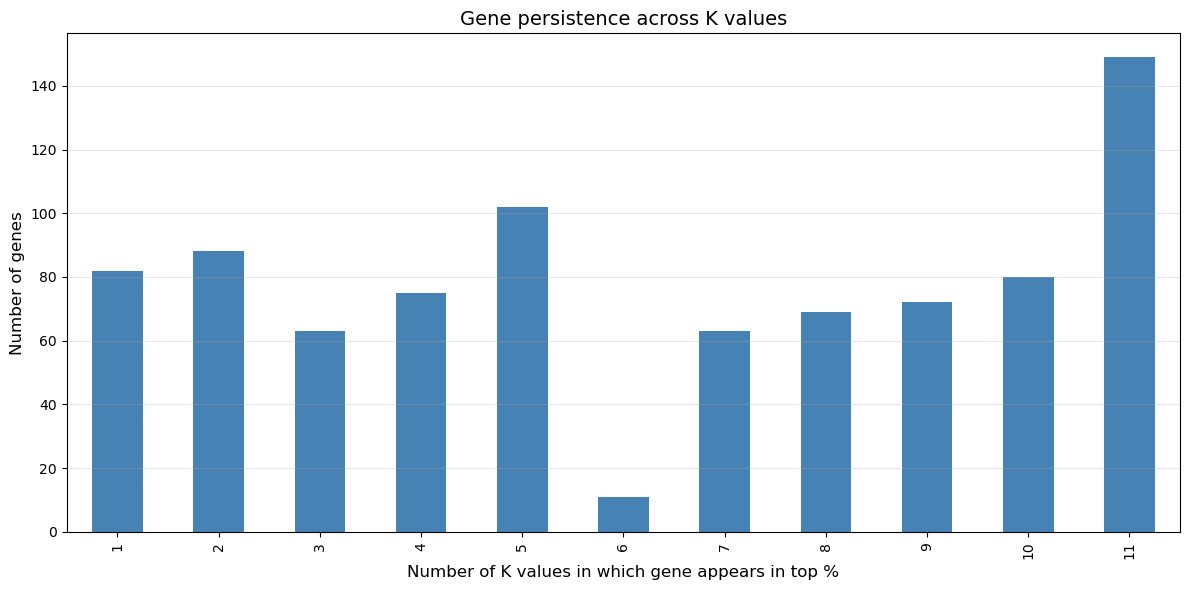

In [9]:
fig, counts = plot_gene_persistence(
    'all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs',
    'anal_pc5_c21_S1.filtered',
    range(5, 16)
)
plt.show()


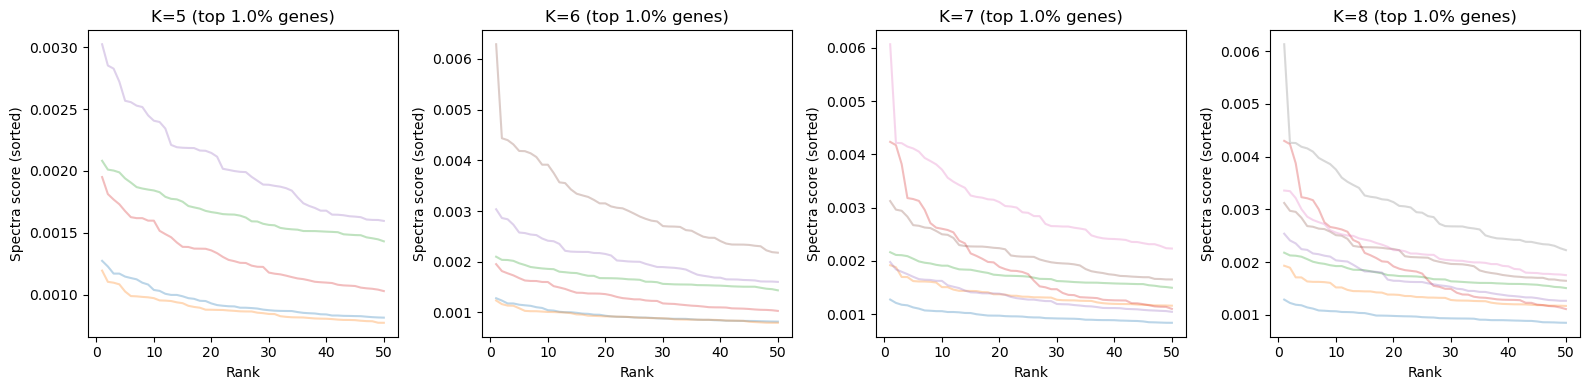

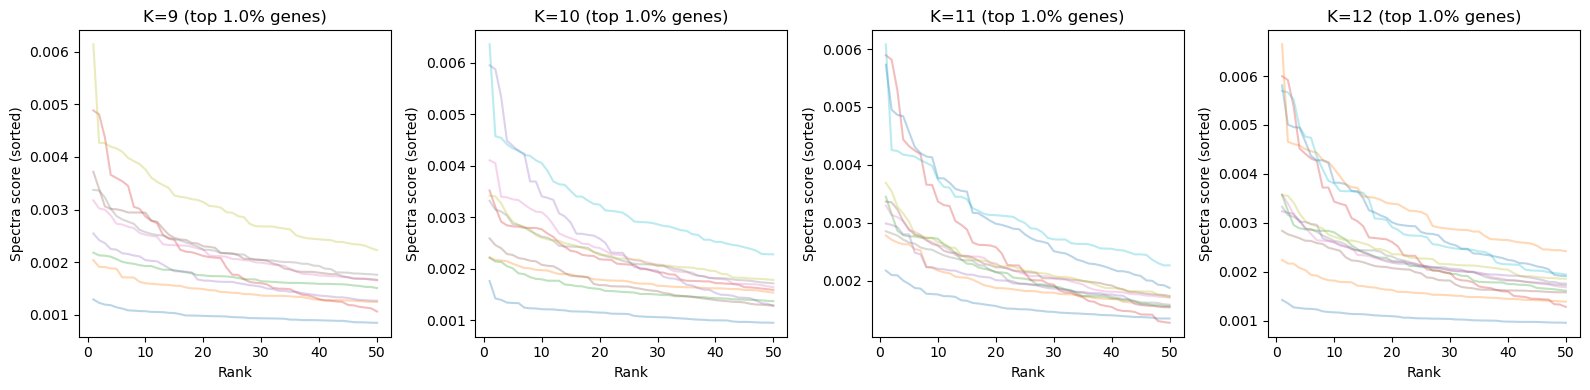

In [12]:
def load_spectra_files(parent_dir, name_prefix, ks):
    """Load gene_spectra_score matrices into a dict[K] -> DataFrame."""
    spectra = {}
    for k in ks:
        pattern = os.path.join(
            parent_dir,
            f"{name_prefix}.gene_spectra_score.k_{k}.*.txt"  # matches dt_0_01 etc.
        )
        files = glob.glob(pattern)
        if not files:
            print(f"No file found for K={k} with pattern {pattern}")
            continue
        fn = files[0]
        df = pd.read_csv(fn, sep="\t", index_col=0)
        spectra[k] = df
    return spectra

def plot_ranked_spectra_top_frac(spectra_dict, top_frac=0.01, max_k_per_fig=4):
    """
    spectra_dict: {K: DataFrame(K x G)}
    top_frac: fraction of genes to keep (e.g., 0.01 for top 1%)
    """
    ks = sorted(spectra_dict.keys())
    n_figs = int(np.ceil(len(ks) / max_k_per_fig))

    for fig_i in range(n_figs):
        fig_ks = ks[fig_i * max_k_per_fig:(fig_i+1) * max_k_per_fig]
        n_cols = len(fig_ks)
        plt.figure(figsize=(4 * n_cols, 4))

        for i, k in enumerate(fig_ks, 1):
            df = spectra_dict[k]
            n_genes = df.shape[1]
            top_n = max(1, int(np.ceil(top_frac * n_genes)))

            ax = plt.subplot(1, n_cols, i)
            for gep_idx in range(df.shape[0]):
                scores = df.iloc[gep_idx].values
                scores_sorted = np.sort(scores)[::-1]
                ax.plot(range(1, top_n + 1),
                        scores_sorted[:top_n],
                        alpha=0.3)

            ax.set_title(f"K={k} (top {top_frac*100:.1f}% genes)")
            ax.set_xlabel("Rank")
            ax.set_ylabel("Spectra score (sorted)")
        plt.tight_layout()
        plt.show()


parent_dir = "all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs"
name_prefix = "anal_pc5_c21_S1.filtered"
ks = range(5, 13)
spectra = load_spectra_files(parent_dir, name_prefix, ks)
plot_ranked_spectra_top_frac(spectra, top_frac=0.01)

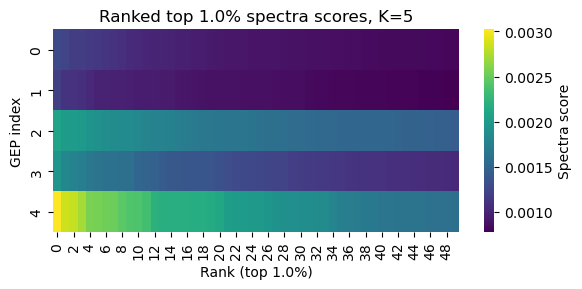

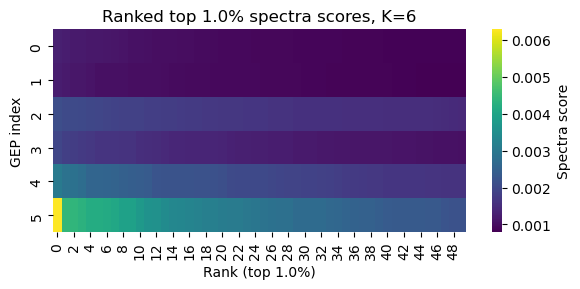

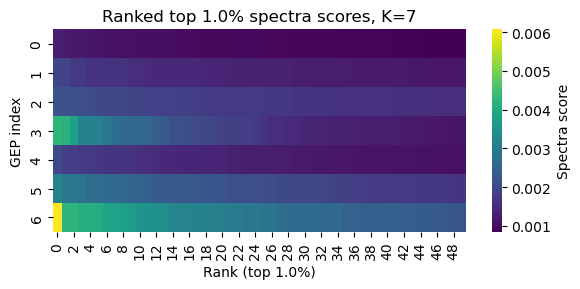

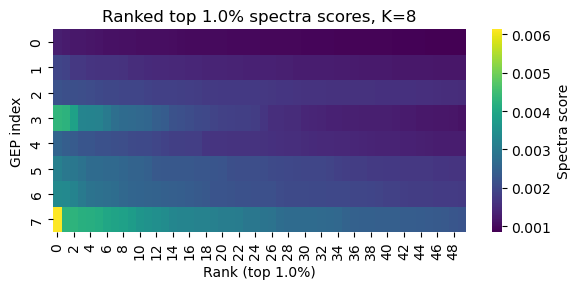

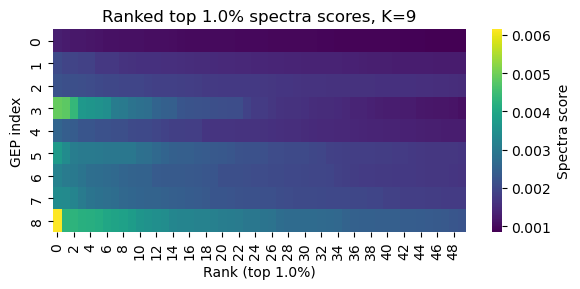

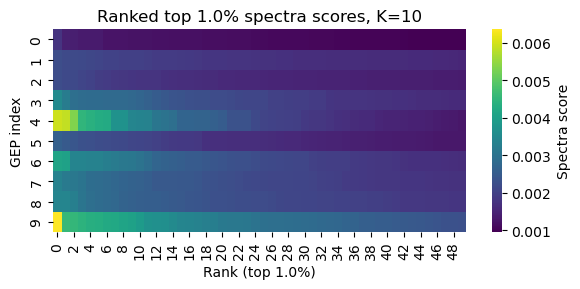

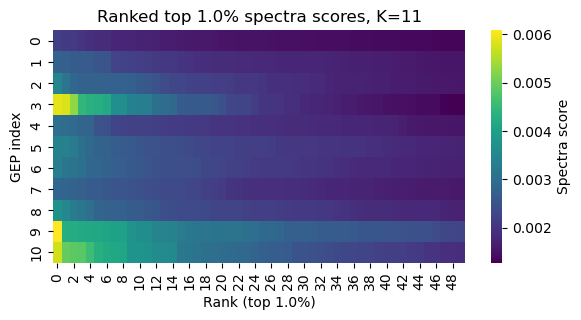

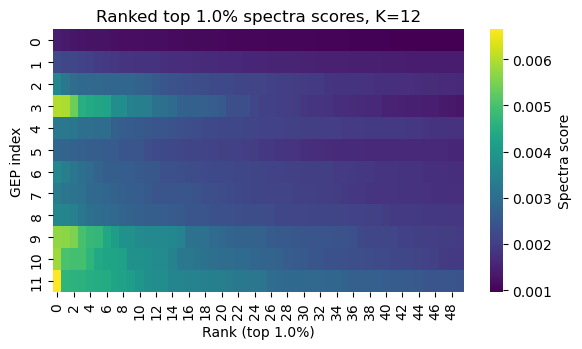

In [13]:
def build_ranked_matrix(df, top_frac=0.01):
    """
    df: K x G DataFrame (GEPs x genes).
    Returns: (K x top_n) numpy array of sorted top scores for each GEP.
    """
    n_genes = df.shape[1]
    top_n = max(1, int(np.ceil(top_frac * n_genes)))
    ranked = []
    for gep_idx in range(df.shape[0]):
        s = df.iloc[gep_idx].values
        s_sorted = np.sort(s)[::-1]
        ranked.append(s_sorted[:top_n])
    return np.vstack(ranked)

def plot_ranked_heatmap_for_k(spectra_dict, k, top_frac=0.01):
    df = spectra_dict[k]
    ranked = build_ranked_matrix(df, top_frac=top_frac)

    plt.figure(figsize=(6, max(3, df.shape[0] * 0.3)))
    sns.heatmap(ranked,
                cmap="viridis",
                cbar_kws={"label": "Spectra score"})
    plt.xlabel("Rank (top {:.1f}%)".format(top_frac * 100))
    plt.ylabel("GEP index")
    plt.title(f"Ranked top {top_frac*100:.1f}% spectra scores, K={k}")
    plt.tight_layout()
    plt.show()

parent_dir = "all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs"
name_prefix = "anal_pc5_c21_S1.filtered"
ks = range(5, 13)
spectra = load_spectra_files(parent_dir, name_prefix, ks)
for k in spectra.keys():
    plot_ranked_heatmap_for_k(spectra, k, top_frac=0.01)